
## Step 1: Initialise the quantum and classical registers 



## 量子相位估計


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import time


qnum = 9
q = QuantumRegister(qnum + 1, 'q')
c = ClassicalRegister(qnum, 'c')
shots = 8192
start_time = time.time()
circuit = QuantumCircuit(q,c)


# Step 2: Put the counting qubits in to Superposition




In [2]:
for i in range(qnum):
    circuit.h(q[i])
circuit.x(q[qnum]) # Flips Q[qnum] to 1



# Step 3: Apply unitary operations 





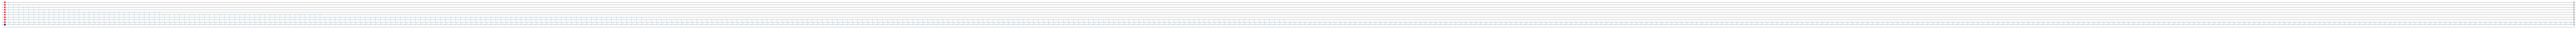

In [3]:
from math import pi
import time
actual_phase = 0.198
angle = 2*pi*actual_phase 

start_gate=time.time()
for i in range(qnum):
    for _ in range(2 ** i):
        circuit.cp(angle, q[i], q[qnum])

end_gate=time.time()
circuit.barrier()
#circuit.draw('mpl')
circuit.draw('mpl', fold=-1)


## Step 4: Apply an inverse QFT


In [4]:
import numpy as np
for j in range(qnum // 2):   # Bit-reverse swap
    circuit.swap(q[j], q[qnum - j - 1])
for j in range(qnum):  # Inverse QFT gates
    circuit.h(q[j])
    for k in range(j + 1, qnum):
        circuit.cp(-np.pi / (2 ** (k - j)), q[j], q[k])

circuit.barrier()
circuit.draw('mpl', fold=-1)



# Step 5: Measure the qubits 


In [5]:
for i in range(qnum):
    circuit.measure(q[i], c[i])

#circuit.draw('mpl')
circuit.draw('mpl', fold=-1)


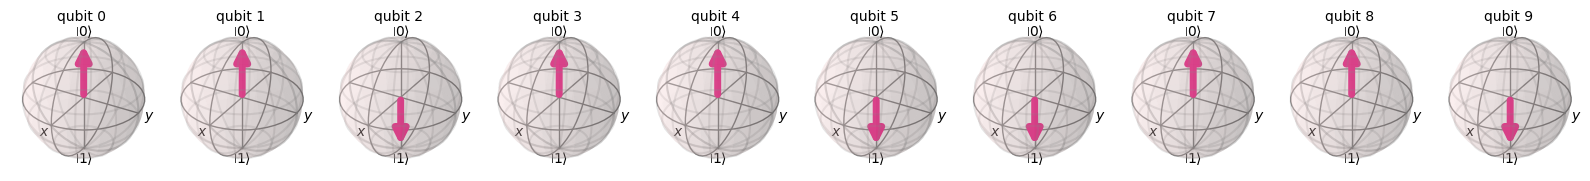

In [6]:
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer import Aer
sim = Aer.get_backend("aer_simulator")
circuit_init = circuit.copy()
circuit_init.save_statevector()
statevector = sim.run(circuit_init).result().get_statevector()
plot_bloch_multivector(statevector)

## Step 6: Run the circuit and obtain the results 


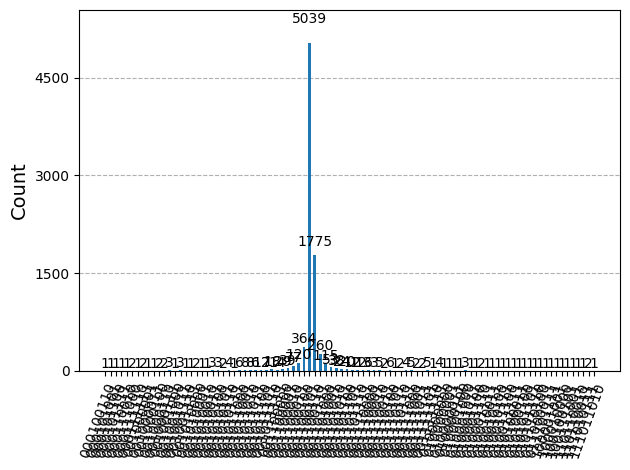

In [7]:
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(circuit, backend)

# 執行電路
job = backend.run(compiled_circuit, shots=shots)
result = job.result()

counts = result.get_counts()
plot_histogram(counts)


## Step 7:  obtain the higher 10 results 

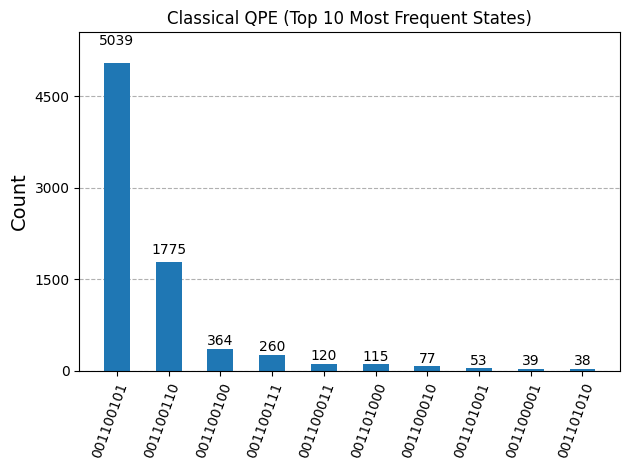

In [8]:
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from collections import Counter

top_counts = dict(Counter(counts).most_common(10))
plot_histogram(top_counts, sort='value_desc', title="Classical QPE (Top 10 Most Frequent States)")

## Step 8: Estimate the Phase 

In [9]:


print("Phase estimation output")
a = max(counts, key=counts.get)



bin_a = int(a,2) # Converts the binary value to an integer
phase = bin_a/(2**qnum) # The calculation used to estimate the phase
end_time = time.time()
print(f"\n[Classical QPE]")
print('qubit number is: ',qnum)
print(f'Most frequent measurement: ',a)
print(f"Estimated phase :{phase:.9f}")
print(f"True phase :     {actual_phase:.9f}")
print(f"Absolute error:  {abs(phase - actual_phase):.9f}")
print("circuit Depth:", circuit.depth())
print(f"Total time：{end_time - start_time:.6f} 秒")



Phase estimation output

[Classical QPE]
qubit number is:  9
Most frequent measurement:  001100101
Estimated phase :0.197265625
True phase :     0.198000000
Absolute error:  0.000734375
circuit Depth: 531
Total time：32.083330 秒


c:\miniconda\envs\qiskit310\lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
C:\Users\Chung Wan Ting\AppData\Local\Temp\ipykernel_18008\1833292600.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


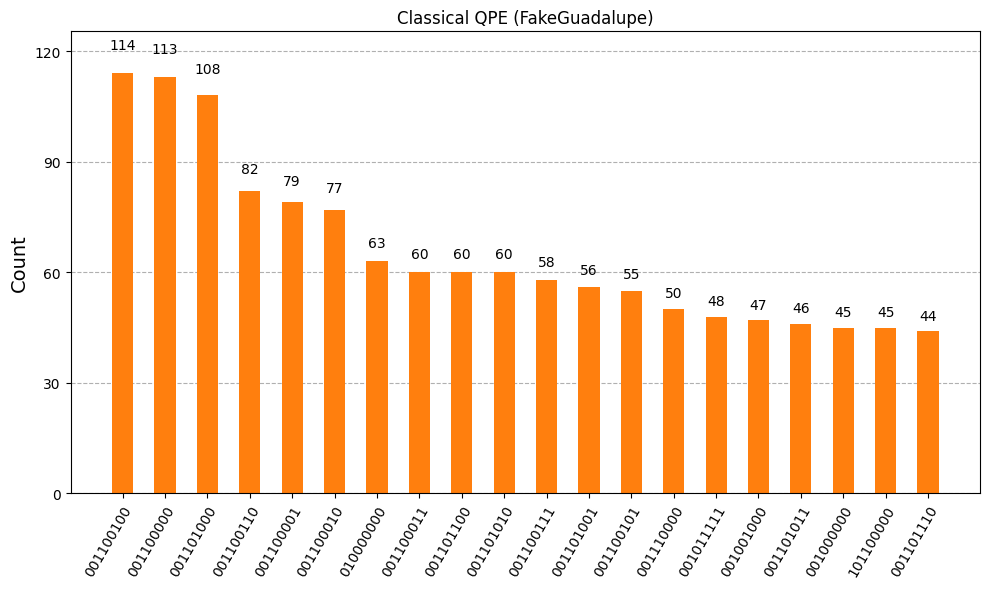

In [10]:
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2  # or FakeTorontoV2, FakeKolkataV2, FakeMumbaiV2
from qiskit_aer.noise import NoiseModel
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator  
from qiskit.quantum_info import Operator
from matplotlib import pyplot as plt
from qiskit.circuit.library import StatePreparation
%matplotlib inline

fake = FakeGuadalupeV2()
noise_model  = NoiseModel.from_backend(fake)
basis_gates  = noise_model.basis_gates
coupling_map = fake.configuration().coupling_map

noisy_backend = AerSimulator(noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates)
tqc_noisy = transpile(circuit, backend=noisy_backend,
                          basis_gates=basis_gates,
                          coupling_map=coupling_map,
                          optimization_level=1)
result_noisy = noisy_backend.run(tqc_noisy, shots=shots).result()
counts_noisy = result_noisy.get_counts()
most_noisy = max(counts_noisy, key=counts_noisy.get)
est_noisy = int(most_noisy, 2) / (2 ** qnum)



total = sum(counts_noisy.values())
fig = plot_histogram(
    counts_noisy,
    number_to_keep=20,
    sort='value_desc',
    bar_labels=True,
    title=f"Classical QPE (FakeGuadalupe)",
    figsize=(10,6),
    color='tab:orange' 
    )
ax = fig.axes[0]
ax.set_ylabel("Count")
for t in ax.get_xticklabels():
    t.set_rotation(60); 
    t.set_ha('right')
fig.tight_layout()
fig.show()

